In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# One of the modules reports prodigious warnings so we will just hide these ;)
import warnings
warnings.filterwarnings("ignore")

/Users/riyarampalli/miniforge3/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
time = np.arange(144)
trend = time * 2.65 +100 #slope and y-intercept 

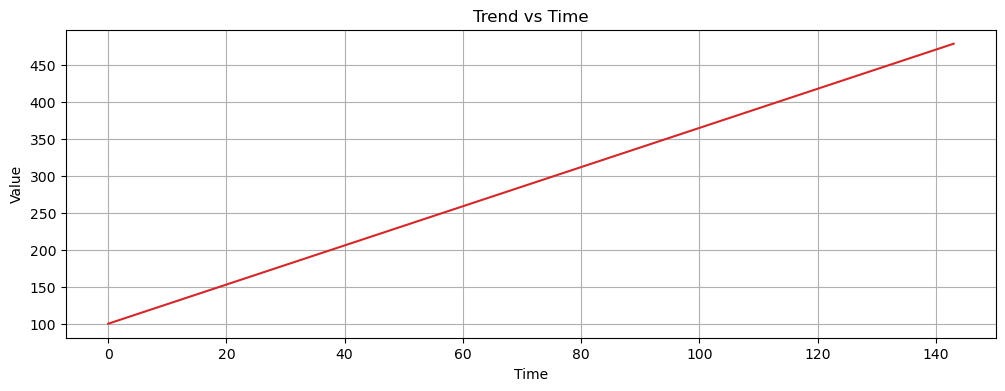

In [3]:
plt.figure(figsize=(12, 4))

plt.plot(time, trend, color='tab:red')
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid()
plt.title("Trend vs Time");

In [4]:
seasonal = 20 + np.sin( time * 0.5) * 20

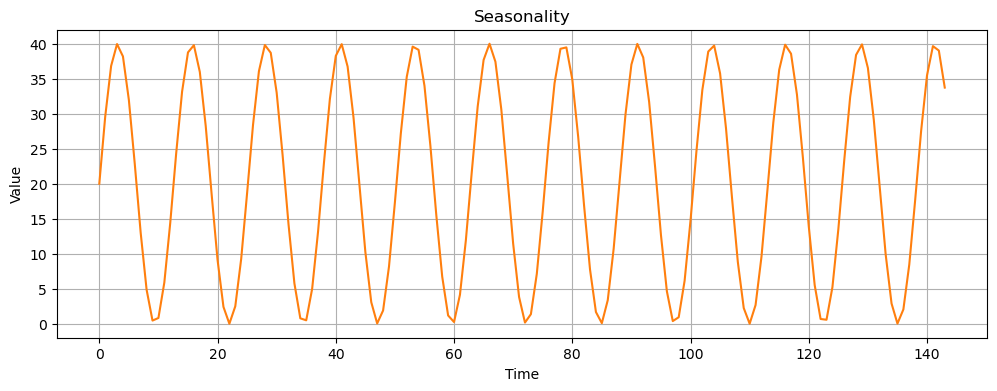

In [5]:
plt.figure(figsize=(12, 4))

plt.plot(time, seasonal, color='tab:orange')
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid()
plt.title("Seasonality");

In [6]:
residuals = np.random.normal(loc=0.0, scale=3, size=len(time))

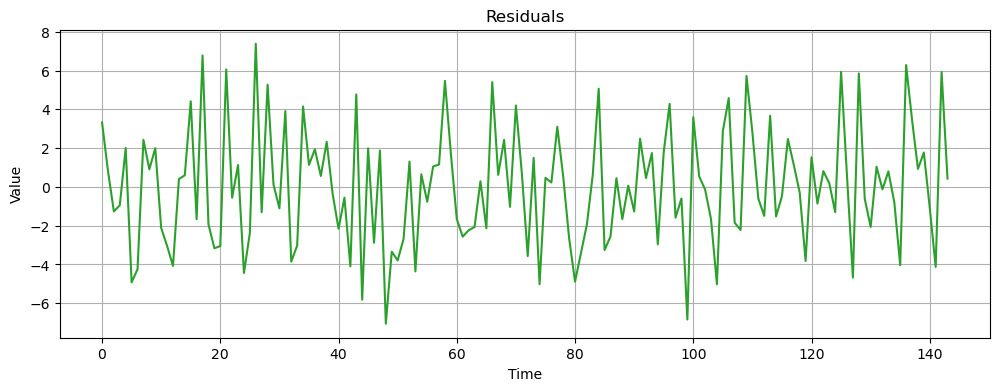

In [7]:
plt.figure(figsize=(12, 4))

plt.plot(time, residuals, color='tab:green')
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid()
plt.title("Residuals");
#residuals equivalent to stochasticity in a system; the trend will/should ALWAYS dominate

In [8]:
additive = trend + seasonal + residuals
#residuals are 'error' terms 

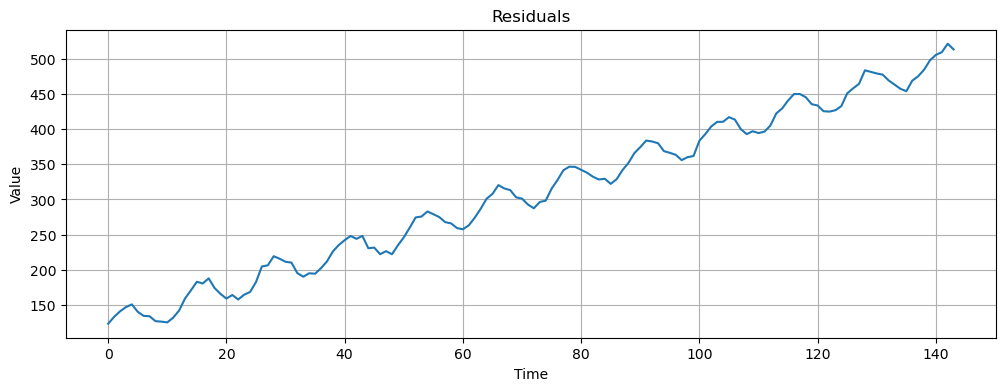

In [9]:
plt.figure(figsize=(12, 4))

plt.plot(time, additive, color='tab:blue')
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid()
plt.title("Residuals");

In [10]:
multiplicative = trend * seasonal # * np.abs(residuals) # <- Plotting w/o residuals to show the pattern

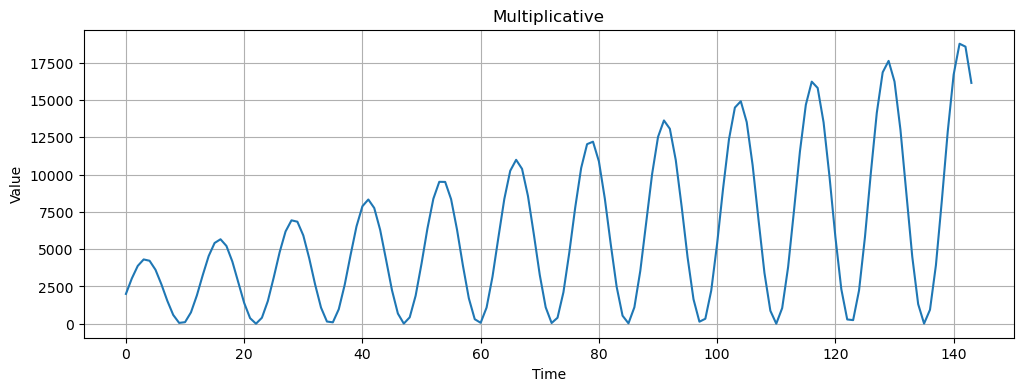

In [11]:
plt.figure(figsize=(12, 4))

plt.plot(time, multiplicative, color='tab:blue')
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid()
plt.title("Multiplicative");

In [12]:
slope, intercept = np.polyfit(np.arange(len(additive)), additive, 1) # estimate line coefficient
#polynomial 1 ^
trend = np.arange(len(additive)) * slope + intercept # linear trend
#plot trend ^
detrended = additive - trend # remove the trend
#we are identfying slope and intercept of trend AND THEN pull out de-trended (seasonality, green)


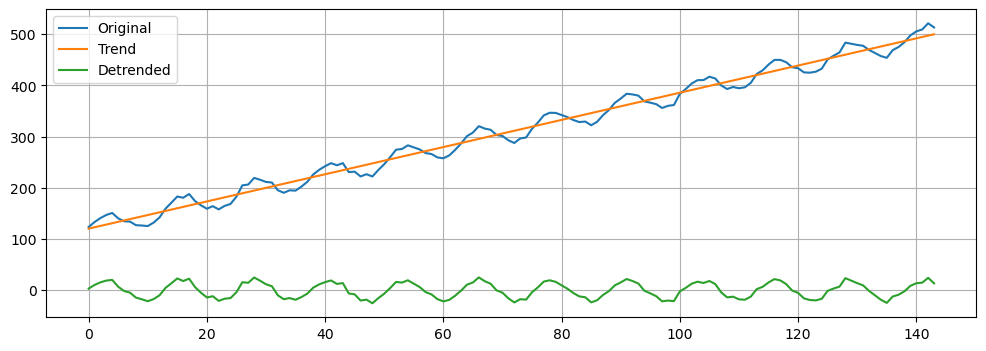

In [13]:
plt.figure(figsize=(12, 4))
plt.plot(additive, label='Original')
plt.plot(trend, label='Trend')
plt.plot(detrended, label='Detrended')
plt.grid()
plt.legend();

In [14]:
additive_decomposition = seasonal_decompose(x=additive, model='additive', period = 12)
#x is the timeseries, the model is additive, and we are providing the model with a period of time 

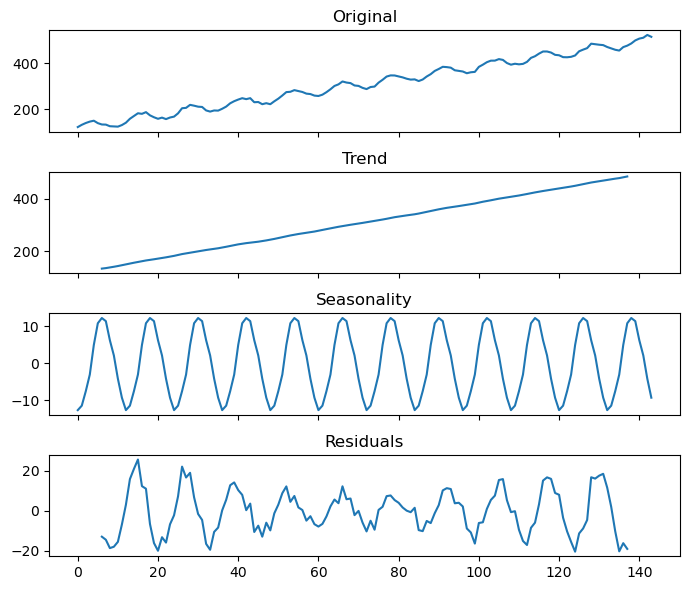

In [15]:
# A helper function to plot the original time series, and the 3 decomposed components
def seas_decomp_plots(original, decomposition):
    _, axes = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(7, 6))
    axes[0].plot(original)
    axes[0].set_title('Original')
    axes[1].plot(decomposition.trend)
    axes[1].set_title('Trend')
    axes[2].plot(decomposition.seasonal)
    axes[2].set_title('Seasonality')
    axes[3].plot(decomposition.resid)
    axes[3].set_title('Residuals')
    plt.tight_layout()
    plt.show()
seas_decomp_plots(additive, additive_decomposition)
#if value for period > 12 then 

### Challenge Exercise
Implement 'seasonal_decompose' for the multiplicative model.
Evaluate the results.

In [16]:
multiplicative_decomp = seasonal_decompose(x = multiplicative, model = 'multiplicative', period = 5) # <- Plotting w/o residuals to show the pattern

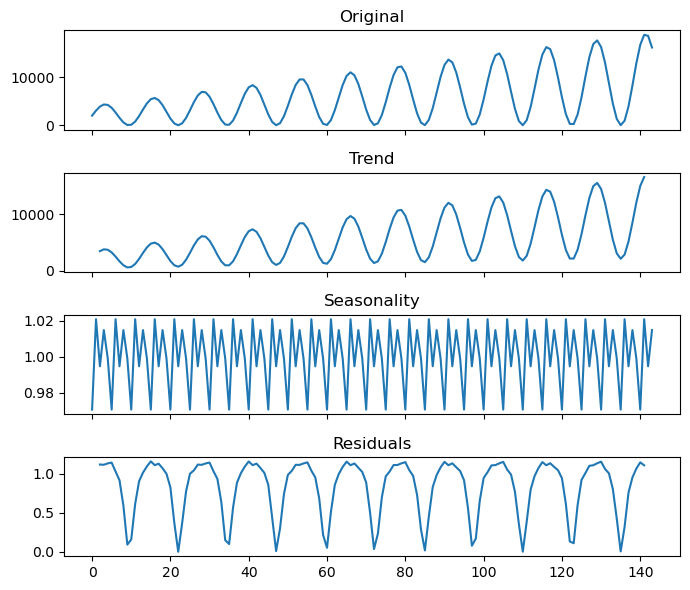

In [17]:
# A helper function to plot the original time series, and the 3 decomposed components
def seas_decomp_plots(original, decomposition):
    _, axes = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(7, 6))
    axes[0].plot(original)
    axes[0].set_title('Original')
    axes[1].plot(decomposition.trend)
    axes[1].set_title('Trend')
    axes[2].plot(decomposition.seasonal)
    axes[2].set_title('Seasonality')
    axes[3].plot(decomposition.resid)
    axes[3].set_title('Residuals')
    plt.tight_layout()
    plt.show()
seas_decomp_plots(multiplicative, multiplicative_decomp)

In [18]:
## Get the length of our input time series
max_x = additive.shape[-1]
max_x

144

First we need to split our additive data into a test and train set, with the idea that we will train ARIMA on the train data. Once the model is fitted, you can use it to forecast future values by calling the predict method, then we can compare the prediction to the ‘true’ values to see how well it did.

Text(0.5, 0, 'Time')

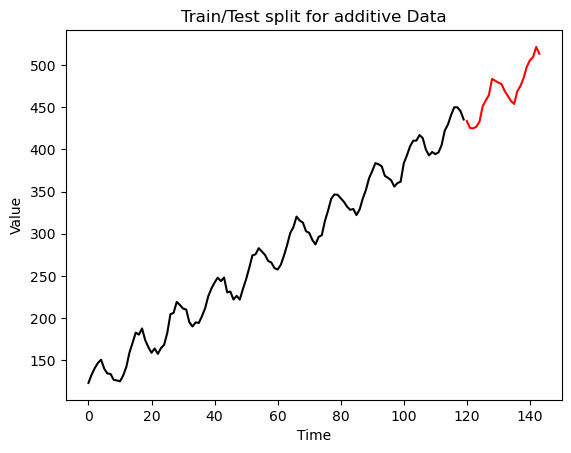

In [19]:
# We'll split at index 120, which will leave 24 timepoints to predict in the train set
split_idx = 120 #this is the number of values for 'test data'

# For plotting we need x-coords for the full dataset so make a list of [1, 2, .., max_x]
xs = list(range(max_x))

# Split the train data and the x-coords
train = additive[:split_idx] #taking additive data and splitting based on first x elements
xs_train = xs[:split_idx]

# Split the test data and the remaining x-coords
test = additive[split_idx:] #opposite (of above) for the test data! 
xs_test = xs[split_idx:]

# Plot the test and train data to see the 'truth' value of the test set
plt.plot(xs_train, train, color = "black")
plt.plot(xs_test, test, color = "red")
plt.title("Train/Test split for additive Data")
plt.ylabel("Value")
plt.xlabel("Time")

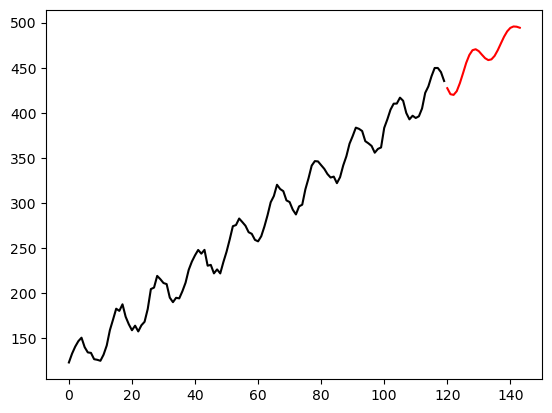

In [20]:
from pmdarima.arima import auto_arima

# Train the model on the training data
model = auto_arima(train) #create model 
model.fit(train)

# Predict the next n timepoints corresponding to the length of the test set
forecast = model.predict(n_periods=len(test)) #predict the model 

# Plot the results
plt.plot(xs_train, train, color = "black")
plt.plot(xs_test, forecast, color = "red")

### Challenge Exercise
The ARIMA model does pretty well when the size of the training set is large (>100 samples) and the size of the forecast is small. Try increasing the size of the n_periods to forecast and plotting this. Think about how the model will behave as predictions go farther into the future. How long will it take before the predictions start to look like noise?

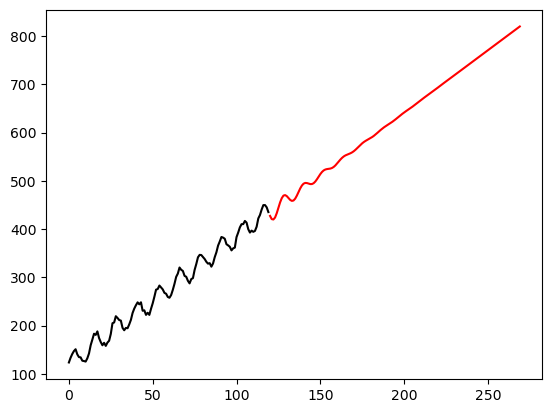

In [23]:
# Lets say you want to predict 100 timepoints in the future you can update the xs_test x-coords like this
n_periods = 150 #have to define this first!

#we have already trained model and fit it to the data:
forecast = model.predict(n_periods= n_periods) #predict the model

xs_test = list(range(split_idx, split_idx +n_periods)) #range gives us increment of integers starting at max_x and going to something even bigger

# Plot the results
plt.plot(xs_train, train, color = "black")
plt.plot(xs_test, forecast, color = "red")

### Challenge Exercises

The statsmodels library has several different timeseries datasets built in. Here you will load two different time series example datasets and work through the analysis that we just practiced above.

Step 1. Plot the two timeseries 
Step 2. Determine if time series look like additive or multiplicative models
Step 3. Decompose each time series into component parts (assume a period of 12)
Step 4. Split each dataset into test and train sets AND train an ARIMA model. Predict the held-out test set.

**How does ARIMA perform on each of these datasets?**

In [24]:
import statsmodels.api as smf
ts_A = sm.datasets.get_rdataset("AirPassengers", "datasets").data["value"].values
print(len(ts_A)) #length of timeseries A
ts_B = sm.datasets.get_rdataset("co2", "datasets").data["value"].values
print(len(ts_B)) #length of timeseries B
#This step is useful so we can know how to split up the train/test data for each 

144
468


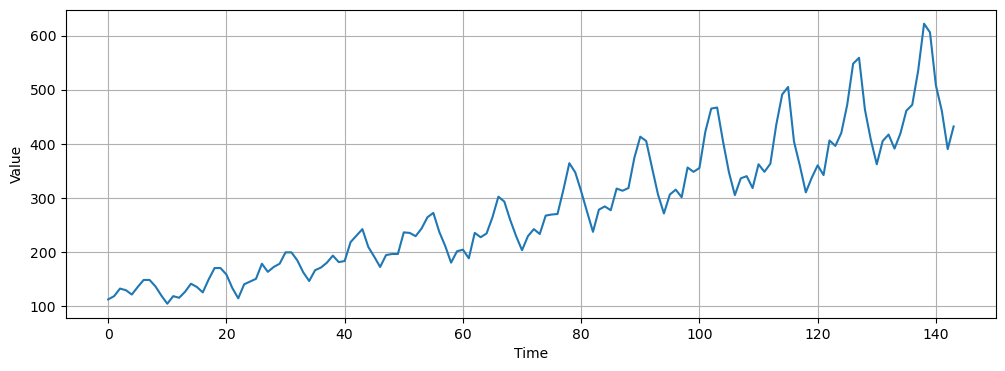

In [27]:
#Plot timeseries A:
plt.figure(figsize=(12, 4))
plt.plot(time, ts_A, color='tab:blue')
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid()

ValueError: x and y must have same first dimension, but have shapes (144,) and (468,)

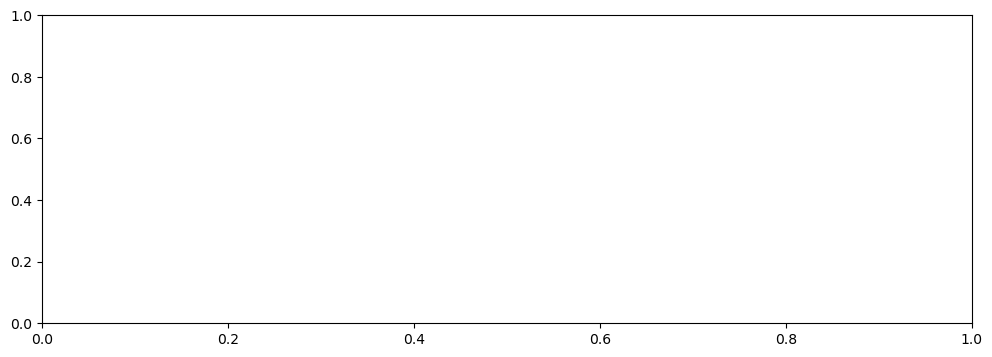

In [28]:
#Plot timeseries B:
plt.figure(figsize=(12, 4))
plt.plot(time, ts_B, color='tab:blue')
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid()

In [ ]:
#For timeseries A:
"""
Split index at 110, which will leave out 34 timepoints to predict in the training set
"""
split_idx = 110 #this is the number of values for 'test data'

# For plotting we need x-coords for the full dataset so make a list of [1, 2, .., max_x]
xs = list(range(max_x))

# Split the train data and the x-coords
train = additive[:split_idx] #taking additive data and splitting based on first x elements
xs_train = xs[:split_idx]

# Split the test data and the remaining x-coords
test = additive[split_idx:] #opposite (of above) for the test data! 
xs_test = xs[split_idx:]

# Plot the test and train data to see the 'truth' value of the test set
plt.plot(xs_train, train, color = "black")
plt.plot(xs_test, test, color = "red")
plt.title("Train/Test split for additive Data")
plt.ylabel("Value")
plt.xlabel("Time")